### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel M9',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "type": None,
    "B": 11.45,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2.75,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 2200.0,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "P_hotel_perc": 0.05,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 1990,
}             



In [4]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

### Set vessel properties and sailing conditions ( input value )

In [5]:
V_s = np.linspace(0.1, 8, 200)          # ship sailing speeds to water, (m/s)
h_0 = [10, 7.5, 5, 3.5]                 # water depths,(m)
C_year = [1970, 1980, 1990, 2000, 2010, 2020]   # engine construction years


### prepare input matrix for calculation

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(C_year, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"C_year": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,C_year,h_0,V_s
4795,2020,3.5,7.841206
4796,2020,3.5,7.880905
4797,2020,3.5,7.920603
4798,2020,3.5,7.960302
4799,2020,3.5,8.000000


### Run OpenTNSim to Calculate resistance, required power and emissions 

In [7]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    C_year = row['C_year']
    data_vessel_i = data_vessel.copy()
    data_vessel_i['C_year'] = C_year
    vessel = TransportResource(**data_vessel_i)
    
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
    print(h_0)
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    P_tot = vessel.calculate_total_power_required(V_s)
    vessel.emission_factors_general()
    vessel.correction_factors(V_s)
    vessel.calculate_emission_factors_total(V_s)
    Fuel_g_m = vessel.calculate_fuel_use_g_m(V_s)
    [emission_g_m_CO2,emission_g_m_PM10,emission_g_m_NOX] = vessel.calculate_emission_rates_g_m(V_s)
    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['P_tot'] = P_tot
    result['Fuel_g_km'] = Fuel_g_m * 1000
    result['emission_g_km_CO2'] = emission_g_m_CO2 * 1000
    result['emission_g_km_PM10'] = emission_g_m_PM10 * 1000
    result['emission_g_km_NOX'] = emission_g_m_NOX * 1000
    results.append(result)

16it [00:00, 155.64it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


49it [00:00, 159.33it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


84it [00:00, 165.71it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


118it [00:00, 165.77it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


152it [00:00, 163.10it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


169it [00:01, 148.67it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


185it [00:01, 134.62it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


216it [00:01, 137.86it/s]

10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


250it [00:01, 151.41it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


285it [00:01, 159.50it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


319it [00:02, 163.12it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


336it [00:02, 161.71it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


369it [00:02, 138.99it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


384it [00:02, 130.54it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


415it [00:02, 134.35it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


432it [00:02, 143.14it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


467it [00:03, 156.02it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


501it [00:03, 160.13it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


535it [00:03, 155.10it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


551it [00:03, 139.60it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


580it [00:03, 123.84it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


593it [00:04, 118.25it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5


623it [00:04, 132.67it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


657it [00:04, 148.68it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


691it [00:04, 157.03it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


707it [00:04, 156.86it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


738it [00:05, 133.28it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


752it [00:05, 127.07it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


778it [00:05, 119.20it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


805it [00:05, 121.12it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
10.0
10.0
10.0
10.0
10.0


823it [00:05, 136.90it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


859it [00:05, 156.09it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


895it [00:06, 166.02it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


930it [00:06, 168.07it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


964it [00:06, 158.18it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


980it [00:06, 143.29it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1011it [00:06, 139.90it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1029it [00:07, 149.64it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1065it [00:07, 163.08it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1101it [00:07, 169.56it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1136it [00:07, 168.98it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1153it [00:07, 159.63it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1185it [00:08, 135.97it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1199it [00:08, 129.56it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1235it [00:08, 150.78it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1271it [00:08, 163.31it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1307it [00:08, 168.11it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1324it [00:08, 167.70it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1357it [00:09, 142.07it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1372it [00:09, 133.20it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


1400it [00:09, 124.72it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1436it [00:09, 148.95it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1472it [00:09, 162.72it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1507it [00:10, 166.39it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1524it [00:10, 151.29it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1540it [00:10, 139.33it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1569it [00:10, 127.79it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1595it [00:10, 122.67it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


1630it [00:11, 145.06it/s]

3.5
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1648it [00:11, 153.65it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1684it [00:11, 165.11it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1719it [00:11, 166.58it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1753it [00:11, 161.82it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1770it [00:11, 141.23it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1785it [00:12, 127.33it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


1814it [00:12, 127.81it/s]

10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1846it [00:12, 139.83it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1878it [00:12, 145.67it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1894it [00:12, 149.17it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1927it [00:13, 152.68it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1959it [00:13, 141.07it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1974it [00:13, 130.51it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


1988it [00:13, 117.82it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
5.0


2001it [00:13, 113.86it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2017it [00:13, 123.19it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2033it [00:13, 131.05it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2050it [00:14, 139.91it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2067it [00:14, 147.84it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2084it [00:14, 152.82it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0


2101it [00:14, 156.67it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2118it [00:14, 158.55it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0


2134it [00:14, 152.88it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2150it [00:14, 135.97it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2164it [00:14, 128.26it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2178it [00:15, 123.18it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2191it [00:15, 121.04it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2204it [00:15, 122.52it/s]

5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2220it [00:15, 132.10it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2237it [00:15, 140.42it/s]

3.5
3.5
3.5
3.5
3.5


2254it [00:15, 147.23it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2270it [00:15, 150.79it/s]

3.5
3.5
3.5
3.5
3.5


2287it [00:15, 155.72it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2304it [00:15, 158.18it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2320it [00:15, 148.76it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5


2336it [00:16, 136.41it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2350it [00:16, 128.01it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2364it [00:16, 124.10it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5


2377it [00:16, 121.25it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


2403it [00:16, 119.90it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2439it [00:16, 146.51it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2457it [00:16, 154.36it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2475it [00:17, 160.13it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2493it [00:17, 163.82it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2510it [00:17, 165.50it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2527it [00:17, 166.46it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2544it [00:17, 165.21it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2561it [00:17, 159.74it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2578it [00:17, 142.81it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


2593it [00:17, 133.69it/s]

10.0
10.0
10.0
10.0
10.0
10.0


2607it [00:18, 134.72it/s]

10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2643it [00:18, 153.86it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2661it [00:18, 158.66it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2679it [00:18, 162.08it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2697it [00:18, 165.16it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2715it [00:18, 166.85it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2732it [00:18, 166.71it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2749it [00:18, 160.81it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2766it [00:18, 144.14it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5


2781it [00:19, 133.16it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


2810it [00:19, 132.73it/s]

7.5
7.5
7.5
7.5
7.5
7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2827it [00:19, 141.68it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2843it [00:19, 145.63it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2859it [00:19, 149.41it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2877it [00:19, 155.62it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2895it [00:19, 160.49it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2913it [00:19, 163.42it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2930it [00:20, 163.27it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2947it [00:20, 142.36it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2962it [00:20, 129.49it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


2976it [00:20, 122.63it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0


2989it [00:20, 115.87it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3001it [00:20, 114.97it/s]

5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5


3019it [00:20, 130.41it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3054it [00:21, 150.74it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3071it [00:21, 153.29it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3087it [00:21, 153.77it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3103it [00:21, 154.24it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3119it [00:21, 143.47it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3134it [00:21, 130.83it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5


3148it [00:21, 123.45it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3161it [00:21, 120.29it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3174it [00:21, 117.79it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3186it [00:22, 116.26it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3198it [00:22, 114.87it/s]

3.5
3.5
3.5
3.5
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3215it [00:22, 129.02it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3232it [00:22, 139.43it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3249it [00:22, 146.71it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3267it [00:22, 154.60it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3285it [00:22, 159.89it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3320it [00:22, 165.19it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3337it [00:23, 163.84it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3354it [00:23, 161.85it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3371it [00:23, 146.67it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3386it [00:23, 133.66it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


3400it [00:23, 127.80it/s]

10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5


3417it [00:23, 138.10it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3434it [00:23, 145.79it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3452it [00:23, 153.59it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3486it [00:24, 161.12it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3504it [00:24, 163.84it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3522it [00:24, 166.18it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3539it [00:24, 165.86it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3556it [00:24, 153.97it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3572it [00:24, 139.73it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3587it [00:24, 125.76it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


3601it [00:24, 116.14it/s]

7.5
7.5
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3619it [00:25, 130.52it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3637it [00:25, 142.14it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3655it [00:25, 151.27it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3673it [00:25, 157.09it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3691it [00:25, 161.76it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3709it [00:25, 164.68it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3726it [00:25, 164.95it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3743it [00:25, 152.68it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3759it [00:25, 139.70it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3774it [00:26, 131.21it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3788it [00:26, 124.94it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


3801it [00:26, 123.00it/s]

5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3819it [00:26, 137.31it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3836it [00:26, 145.89it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3854it [00:26, 154.23it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3872it [00:26, 159.59it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3889it [00:26, 162.49it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3906it [00:26, 163.37it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3923it [00:27, 150.12it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3939it [00:27, 138.52it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3954it [00:27, 131.12it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3968it [00:27, 125.90it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


3981it [00:27, 120.94it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5


3994it [00:27, 117.85it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
10.0
10.0
10.0
10.0


4027it [00:27, 138.82it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4045it [00:27, 148.88it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4063it [00:28, 156.86it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4081it [00:28, 161.53it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4099it [00:28, 164.54it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4116it [00:28, 165.43it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4150it [00:28, 165.41it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4167it [00:28, 153.55it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


4183it [00:28, 139.19it/s]

10.0
10.0
10.0
10.0
10.0


4198it [00:29, 131.07it/s]

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4215it [00:29, 139.82it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4233it [00:29, 149.16it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4250it [00:29, 153.31it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4267it [00:29, 156.36it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4284it [00:29, 157.40it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4319it [00:29, 163.54it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4336it [00:29, 163.37it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4353it [00:29, 155.50it/s]

7.5
7.5
7.5
7.5
7.5


4369it [00:30, 140.91it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4384it [00:30, 131.27it/s]

7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5
7.5


4398it [00:30, 124.75it/s]

7.5
7.5
7.5


4414it [00:30, 132.62it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4450it [00:30, 153.30it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4486it [00:30, 163.62it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4521it [00:31, 166.67it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4538it [00:31, 158.71it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4570it [00:31, 133.61it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4584it [00:31, 126.92it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0


4613it [00:31, 131.57it/s]

5.0
5.0
5.0
5.0
5.0
5.0
5.0
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4649it [00:32, 152.12it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4683it [00:32, 159.93it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4700it [00:32, 162.32it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4733it [00:32, 140.40it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4748it [00:32, 131.78it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4775it [00:32, 122.25it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


4800it [00:33, 144.57it/s]

3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5
3.5


In [8]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.head(100)

,C_year,h_0,V_s,P_installed,R_f_one_k1,R_APP,R_W,R_res,R_T,P_tot,Fuel_g_km,emission_g_km_CO2,emission_g_km_PM10,emission_g_km_NOX,V_s_km
0,1970.0,10.0,0.100000,2200.0,0.034195,0.003647,2.338200e-88,0.012007,0.049849,110.008794,89763.890386,288772.345241,447.357222,6039.353504,0.360000
1,1970.0,10.0,0.139698,2200.0,0.062944,0.006714,1.351710e-64,0.023392,0.093049,110.022931,64263.439925,206736.853544,320.258018,4323.541119,0.502915
2,1970.0,10.0,0.179397,2200.0,0.099453,0.010608,5.948859e-51,0.038507,0.148568,110.047018,50053.283455,161022.477839,249.425060,3367.330738,0.645829
3,1970.0,10.0,0.219095,2200.0,0.143433,0.015299,4.713176e-42,0.057335,0.216066,110.083511,40997.151409,131888.708362,204.276293,2757.864410,0.788744
4,1970.0,10.0,0.258794,2200.0,0.194666,0.020764,9.051534e-36,0.079854,0.295284,110.134808,34723.923329,111707.600155,172.994502,2335.609618,0.931658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1970.0,10.0,3.871357,2200.0,29.124258,3.106485,2.592475e+00,15.008164,49.831381,450.319691,8717.897945,28045.663176,22.942996,382.549435,13.936884
96,1970.0,10.0,3.911055,2200.0,29.684104,3.166200,2.784446e+00,15.285450,50.920200,461.321725,8824.836447,28389.686613,23.127325,386.502162,14.079799
97,1970.0,10.0,3.950754,2200.0,30.248928,3.226445,2.987091e+00,15.564582,52.027047,472.601913,8933.761927,28740.102200,23.311643,390.502161,14.222714
98,1970.0,10.0,3.990452,2200.0,30.818723,3.287222,3.250155e+00,15.907966,53.264066,484.953478,9058.233092,29140.528585,23.523720,395.084111,14.365628


### Figures output

### Figure 3: Components of the total resistance

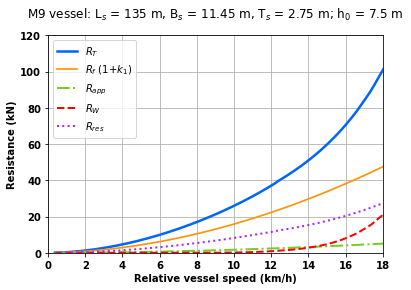

In [9]:
# resistance for water depth h_0 = 7.5 m, 1990
selected = plot_df.query('C_year == 1990 and h_0 == 7.5')

plt.figure(figsize=(6,4))
plt.plot(selected['V_s_km'], selected['R_T'], color='#0165fc', linewidth = 2.5)       # RT, total resistance of the ship,[kN] 
plt.plot(selected['V_s_km'], selected['R_f_one_k1'],color='#ff9408', linewidth = 1.7) # Rf(1+k1), frictional resistance including the hull form factor
plt.plot(selected['V_s_km'], selected['R_APP'],'-.', color='#76cd26',linewidth = 2)   # Rapp, appendage resistance
plt.plot(selected['V_s_km'], selected['R_W'], 'r--', linewidth = 2)                   # Rw, wave resistance
plt.plot(selected['V_s_km'], selected['R_res'],':',color='#aa23ff', linewidth = 2) # Rres, residual resistance
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 120)
plt.legend(['$R_T$', '$R_f$$\ $(1+$k_1$)', '$R_{app}$', '$R_W$','$R_{res}$'])
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Resistance (kN)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')

plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m; h$_0$ = 7.5 m',y=1.05)
plt.savefig('Fig_03.pdf', dpi=600, format='pdf') 


### Figure 5: Total required power

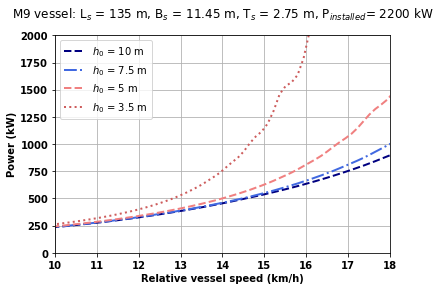

In [10]:

plt.figure(figsize = (6,4))
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='navy',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'-.', color='royalblue',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='lightcoral',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],':', color='indianred',linewidth = 2.0)

plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'])

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW' ,y=1.05)
plt.savefig('Fig_05.pdf', dpi=600, format='pdf') 


### Figure 7: validation_total power required versus speed with diff water depths (add DST results to Fig.5, but squatting is disabled)

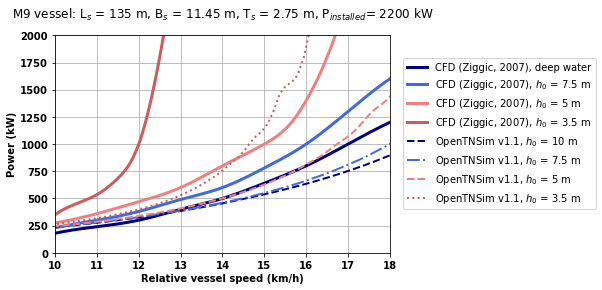

In [11]:
from scipy.interpolate import make_interp_spline, BSpline

plt.figure(figsize = (6,4))
V_DST_1=np.array([10,11,12,13,14,15,16,17,18]) # deep water
P_DST_1=np.array([180,240,300,400,500,640,800,1000,1200])
V_DST_2=np.array([10,11,12,13,14,15,16,17,18]) # h=7.5 m
P_DST_2=np.array([230,300,380,490,600,780,1000,1300,1600])
V_DST_3=np.array([10,11,12,13,14,15,15.65,16,16.5,16.7]) # h=5 m
P_DST_3=np.array([275,360,470,600,800,1000,1200,1400,1800,2005])
V_DST_4=np.array([10,10.5,11,11.5,12,12.5,13]) # h=3.5 m
P_DST_4=np.array([350,450,535,685,1000,1800,3000])
#define spline, make the lines smooth
V_DST_1_new = np.linspace(V_DST_1.min(), V_DST_1.max(), 200) 
V_DST_2_new = np.linspace(V_DST_2.min(), V_DST_2.max(), 200) 
V_DST_3_new = np.linspace(V_DST_3.min(), V_DST_3.max(), 200) 
V_DST_4_new = np.linspace(V_DST_4.min(), V_DST_4.max(), 200) 

spl1= make_interp_spline(V_DST_1,P_DST_1, k=3)
P_DST_1_new = spl1(V_DST_1_new)
spl2= make_interp_spline(V_DST_2,P_DST_2, k=3)
P_DST_2_new = spl2(V_DST_2_new)
spl3= make_interp_spline(V_DST_3,P_DST_3, k=3)
P_DST_3_new = spl3(V_DST_3_new)
spl4= make_interp_spline(V_DST_4,P_DST_4, k=3)
P_DST_4_new = spl4(V_DST_4_new)
                 
plt.plot(V_DST_1_new,P_DST_1_new,color='navy',linewidth = 3.0)
plt.plot(V_DST_2_new,P_DST_2_new,color='royalblue',linewidth = 3.0)
plt.plot(V_DST_3_new,P_DST_3_new,color='lightcoral',linewidth = 3.0)
plt.plot(V_DST_4_new,P_DST_4_new,color='indianred',linewidth = 3.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='navy',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'-.', color='royalblue',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='lightcoral',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],':', color='indianred',linewidth = 2.0)
plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['CFD (Ziggic, 2007), deep water', 'CFD (Ziggic, 2007), $h_0$ = 7.5 m', 'CFD (Ziggic, 2007), $h_0$ = 5 m', 'CFD (Ziggic, 2007), $h_0$ = 3.5 m',
        'OpenTNSim v1.1, $h_0$ = 10 m', 'OpenTNSim v1.1, $h_0$ = 7.5 m', 'OpenTNSim v1.1, $h_0$ = 5 m', 'OpenTNSim v1.1, $h_0$ = 3.5 m'],loc=(1.04,0.2))

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)

plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW',y=1.05)
plt.savefig('Fig_07.pdf',bbox_inches = 'tight',dpi=600, format='pdf') 


### Figure 8: Emissions as a function of vessel speed: emission rates in g/km versus speed for different water depths

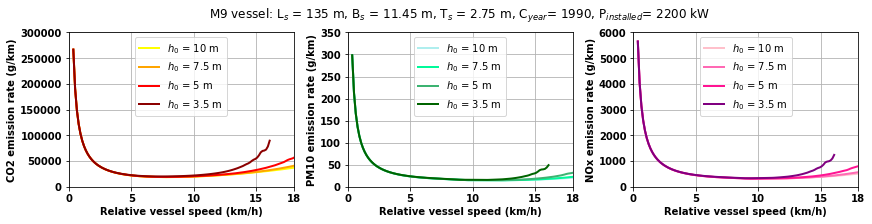

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3),constrained_layout=True)
fontsize=10


ax=plt.subplot(131)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'yellow',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'orange',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'red',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkred',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)  #  set vessel speed range (km/h) for inland shipping
plt.ylim(0, 300000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')


ax=plt.subplot(132)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'paleturquoise',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumspringgreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumseagreen',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'darkgreen',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 350)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, C$_{year}$= 1990, P$_{installed}$= 2200 kW',y=1.05)

ax=plt.subplot(133)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'pink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'hotpink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'deeppink',linewidth = 2.0)

# Select data for this subplot/line
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'purple',linewidth = 2.0)

plt.legend(['$h_0$ = 10 m', '$h_0$ = 7.5 m', '$h_0$ = 5 m', '$h_0$ = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 6000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')


plt.savefig('Fig_08.pdf', dpi=600, format='pdf')  


### Figure 9: Emissions as a function of engine age: emission rates in g/km versus speed for different engine ages


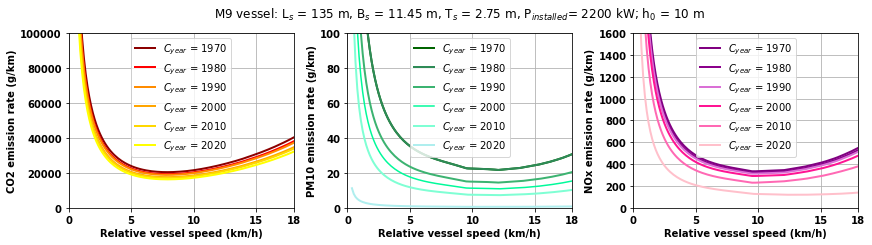

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3.3),constrained_layout=True)
fontsize=10

ax=plt.subplot(131)
# Select data for this subplot/line
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkred',linewidth = 2.0)   

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'red',linewidth = 2.0)      

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'darkorange',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'orange',linewidth = 2.0)    

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'gold',linewidth = 2.0)      

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_CO2'], 'yellow',linewidth = 2.0)    

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100000)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18],weight = 'bold')
plt.yticks( weight = 'bold')

ax=plt.subplot(132)
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'darkgreen',linewidth = 2.0)

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'seagreen',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumseagreen',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'mediumspringgreen')

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'aquamarine',linewidth = 2.0)

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_PM10'], 'paleturquoise',linewidth = 2.0)

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW; h$_0$ = 10 m',y=1.05)

ax=plt.subplot(133)
selected = plot_df.query('C_year == 1970 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'purple',linewidth = 2.0)

selected = plot_df.query('C_year == 1980 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'darkmagenta',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'orchid',linewidth = 2.0)

selected = plot_df.query('C_year == 2000 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'deeppink',linewidth = 2.0)

selected = plot_df.query('C_year == 2010 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'hotpink',linewidth = 2.0)

selected = plot_df.query('C_year == 2020 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['emission_g_km_NOX'], 'pink',linewidth = 2.0)

plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000',
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 1600)
plt.xlabel('Relative vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

plt.savefig('Fig_09.pdf', dpi=600, format='pdf')
